# **Projet Epidemiologie**

$\textcolor{green}{
Maël \ Le \ Guillouzic\\
Alexandre \ Mallez}
$

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from tqdm import tqdm
from matplotlib.patches import FancyArrowPatch

---

## 1. Analyse du Sujet

On cherche à comparer deux modèles sur la diffusion d’un virus :

* **Modèle SIR déterministe** : on suit $(S(t),I(t),R(t))$ quand la population est très grande.
* **Modèle SIR stochastique (Markov)** : on simule chaque infection et guérison dans un groupe fini de $N+1$ personnes.

*On reprendre toutes les notations et équations du poly de L. Decreusefond & P. Moyal*

---

## 2. Modèle SIR

Quand $N$ est grand, la dynamique moyenne obéit au système :

$$
\dot S=-\beta S I,\qquad
\dot I=\beta S I-\gamma I,\qquad
\dot R=\gamma I.
$$

* La flèche $S\to I$ retire $\beta S I$ personnes de $S$ chaque jour.  
* La flèche $I\to R$ en ajoute $\gamma I$ dans $R$.  
* Tout le reste suit.

**Affichons cela sous forme d'un petit schéma pour fixer les idées**

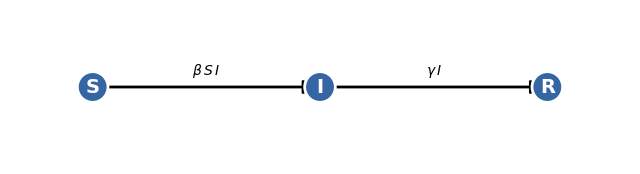

In [2]:
fig, ax = plt.subplots(figsize=(8,2))
ax.set_xlim(0,3); ax.set_ylim(0,2); ax.axis("off")
pts={'S':(0.4,1),'I':(1.5,1),'R':(2.6,1)}
for name,(x,y) in pts.items():
    ax.text(x,y,name,ha='center',va='center',
            fontsize=14,fontweight='bold',
            bbox=dict(boxstyle='circle',fc='#3565a3',ec='white',lw=2),color='white')
arrow=dict(arrowstyle='-|>',lw=2,mutation_scale=20)
ax.add_patch(FancyArrowPatch(pts['S'],pts['I'],**arrow))
ax.add_patch(FancyArrowPatch(pts['I'],pts['R'],**arrow))
ax.text(0.95,1.15,r'$\beta\,S\,I$',ha='center')
ax.text(2.05,1.15,r'$\gamma\,I$',ha='center')
plt.show()

Passons à la partie code.

In [3]:
# Modèle SIR
def modele_SIR(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def resoudre_SIR(beta, gamma, S0=None, I0=None, R0=None, temps_max=160, Aff=True):
    # Initialisation des conditions initiales
    if S0 is None:
        S0 = 0.99 #Proportion de la population initialement susceptible
    if I0 is None:
        I0 = 0.01 #Proportion de la population initialement infectée
    if R0 is None:
        R0 = 0.0  #Proportion de la population initialement retirée
    
    t = np.linspace(0, temps_max, temps_max)
    y0 = [S0, I0, R0]
    solution = odeint(modele_SIR, y0, t, args=(beta, gamma))
    S, I, R = solution.T
    
    if Aff:
        plt.figure(figsize=(10,6))
        plt.plot(t, S, label='Susceptibles (S)')
        plt.plot(t, I, label='Infectés (I)')
        plt.plot(t, R, label='Retirés (R)')
        plt.xlabel('Temps')
        plt.ylabel('Proportion')
        plt.title(f'Modèle SIR - beta={beta}, gamma={gamma}')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        return S, I, R

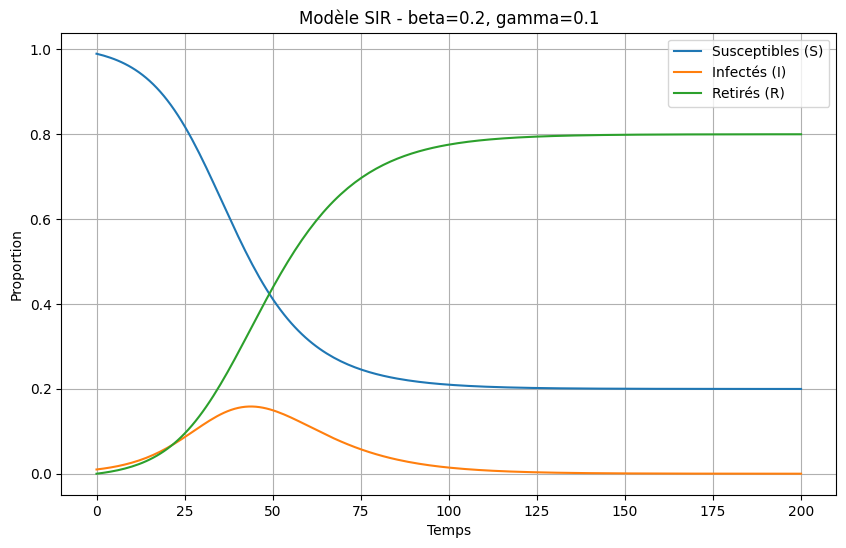

In [4]:
resoudre_SIR(0.2, 0.1, temps_max=200)

---

## 3. Modèle Markovien

Dans le poly le processus $(S,I,R)$ est décrit en temps **continu** :  
$$
(s,i,r)\longrightarrow(s-1,i+1,r),\qquad
(s,i,r)\longrightarrow(s,i-1,r+1). 
$$

On fera le choix pratique de prendre un pas de temps discret = 1 jour.

Ainsi un individu :
* *Susceptible :* devient infecté avec la proba $\displaystyle p_{\text{inf}}=\beta\,\frac{I}{N}$. (Car quand $\beta$ est petit, Bernoulli sur 1 jour approche plutot bien $\exp{(\beta\,\frac{I}{N})}$)
* *Infecté :* se retire avec la proba $p_{\text{ret}}=\gamma$ (avec la meme justification quand $\gamma\ll1$)
* *Retiré :* reste retiré (c'est un état absorbant)

Implémetons cela ci dessous.

In [5]:
# Simulation du processus de Markov
def simulation_Markov(beta, gamma, N, temps_max=160 , Aff = True):
    # 0 = S, 1 = I, 2 = R
    etats = np.zeros(N, dtype=int)
    
    # On initialise : 1% d'infectés
    infectes_initiaux = np.random.choice(N, size=N//100, replace=False)
    etats[infectes_initiaux] = 1
    
    S_hist, I_hist, R_hist = [], [], []
    
    for t in range(temps_max):
        S = np.sum(etats == 0)
        I = np.sum(etats == 1)
        R = np.sum(etats == 2)
        
        S_hist.append(S/N)
        I_hist.append(I/N)
        R_hist.append(R/N)
        
        nouveaux_etats = etats.copy()
        
        for i in range(N):
            if etats[i] == 0: 
                proba_infection = beta * (I/N)
                if np.random.rand() < proba_infection:
                    nouveaux_etats[i] = 1 # Susceptible devient infecté
            elif etats[i] == 1: 
                if np.random.rand() < gamma:
                    nouveaux_etats[i] = 2 # Indecté devient retiré
                    
        etats = nouveaux_etats

    if Aff:
        plt.figure(figsize=(10,6))
        plt.plot(S_hist, label='Susceptibles (S)')
        plt.plot(I_hist, label='Infectés (I)')
        plt.plot(R_hist, label='Retirés (R)')
        plt.xlabel('Temps')
        plt.ylabel('Proportion')
        plt.title(f'Processus de Markov - N= {N}, beta={beta}, gamma={gamma}') 
        plt.legend()
        plt.grid()
        plt.show() 
    else: 
        return S_hist, I_hist, R_hist
    

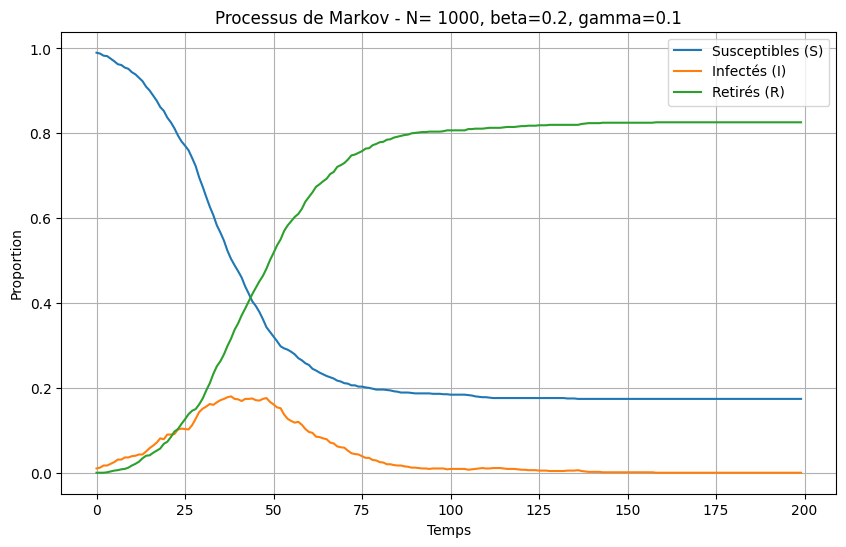

In [6]:
# Exemple de simulation Markov
simulation_Markov(0.2, 0.1, 1000, temps_max=200)

---

### 4.1 Cas particulier - Tout le monde est retiré sur le long terme

En reprenant le cours dans le poly, on pose $R_0 = \frac{\beta}{\gamma}$

La population de «retirés» finale, notée $r_{\infty}$, satisfait l’équation : 
$$1 - r_{\infty} = s(0). exp(- R_0. r_{\infty})$$

Considerer que tout le monde est retiré sur le long terme revient a dire que $r_{\infty} = 1$ 

Et donc $exp(-R_0.r_{\infty}) \to 0$
i.e. $R_0 \to \infty$

On doit donc choisir $\beta > \gamma$, et plus ce ration est grand, plus le resultat sera obtenu.

Cas 1 :


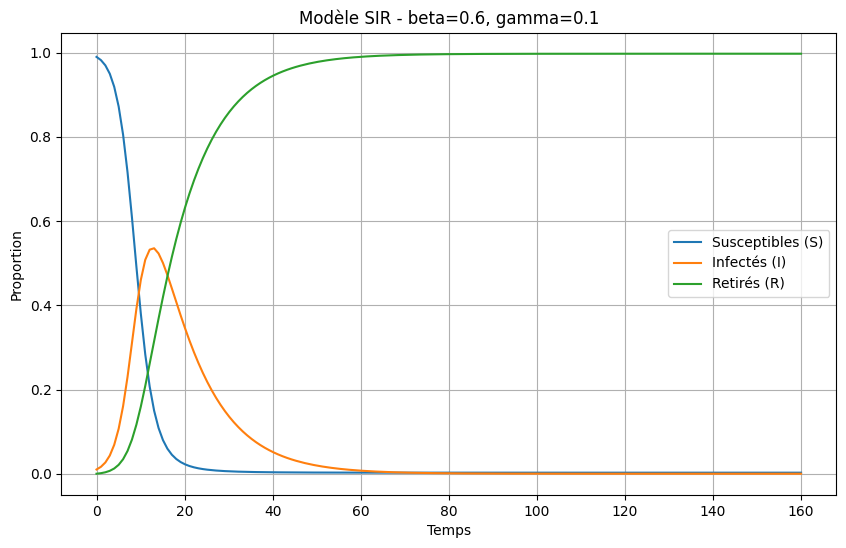

In [7]:
print("Cas 1 :")
resoudre_SIR(beta=0.6, gamma=0.1)

### 4.2 Cas particulier - Une partie de la population reste susceptible et une autre est retirée

De manière similaire au cas ci dessus, on souhaite avoir $R_0$ proche de 1.
* Si $R_0<1$ alors l'épidémie ne se propage pas
* Si $R_0>1$ alors elle se propage.

On va donc prendre $\beta > \gamma$ mais pas de beaucoup.

Cas 2 :


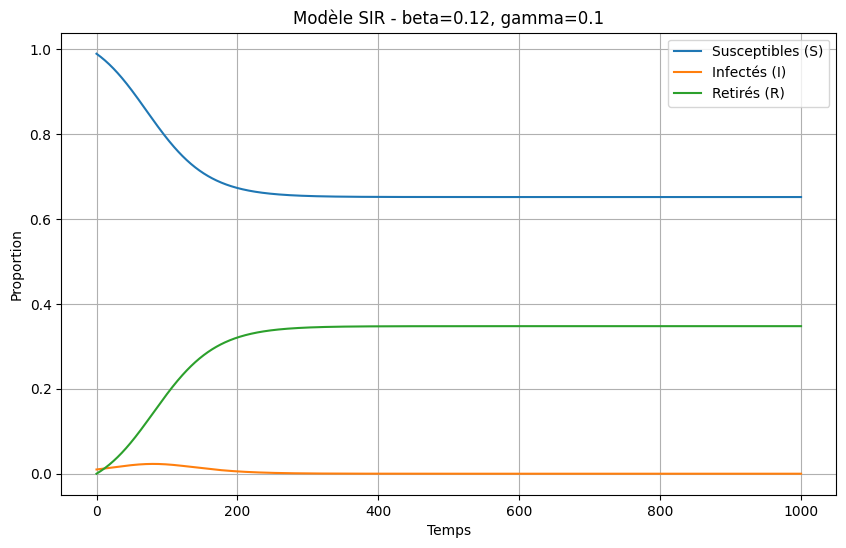

In [8]:
print("Cas 2 :")
resoudre_SIR(beta=0.12, gamma=0.1, temps_max=1000)

---

## 5. Observer la convergence Markov => SIR

Pour cela on adopte l'approche suivante :
1. On fixe un couple $(\beta,\gamma)$ et un horizon temps_max (160 jours).  
2. On fait tourner le simulateur stochastique pour plusieurs tailles de population
3. On trace les courbes moyennes $\widehat S(t),\widehat I(t),\widehat R(t)$. A priori plus N est grand, plus elles « collent ».On tracera aussi la solution déterministe obtenue à la section 2 (`resoudre_SIR`).  
4. Enfin, on calcule numériquement une erreur globale 
$$
E_N=\sum_{t=0}^{T}|\widehat S_N(t)-s(t)|
$$ 

In [9]:
def comparaison(beta, gamma, N_list, moy=10 ,  temps_max=160):
    n_plots = len(N_list)
    n_cols = 2
    n_rows = (n_plots + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)
    axes_flat = axes.flatten() 

    S_hist_Markov = []
    I_hist_Markov = []
    R_hist_Markov = []

    for i in tqdm(range(n_plots)):
        N = N_list[i]
        S_list = []
        I_list = []
        R_list = []
        for j in range(moy):
            S, I, R = simulation_Markov(beta, gamma, N, temps_max=temps_max, Aff=False)
            S_list.append(S)
            I_list.append(I)
            R_list.append(R)

        S_hist_Markov.append(np.mean(S_list, axis=0))
        I_hist_Markov.append(np.mean(I_list, axis=0))
        R_hist_Markov.append(np.mean(R_list, axis=0))

        ax = axes_flat[i]
        ax.plot(S_hist_Markov[i], label='Markov - S')
        ax.plot(I_hist_Markov[i], label='Markov - I')
        ax.plot(R_hist_Markov[i], label='Markov - R')
        ax.set_xlabel('Temps')
        ax.set_ylabel('Proportion')
        ax.set_title(f'N={N}')
        ax.legend(fontsize=8)
        ax.grid()

    # Hide any unused subplots if the number of plots is odd
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    plt.show()

    S_hist_SIR, I_hist_SIR, R_hist_SIR = resoudre_SIR(beta, gamma, temps_max=temps_max, Aff=False)
    plt.figure(figsize=(10,6))
    plt.plot(S_hist_SIR, label='SIR - Susceptibles (S)')
    plt.plot(I_hist_SIR, label='SIR - Infectés (I)')
    plt.plot(R_hist_SIR, label='SIR - Retirés (R)')
    plt.xlabel('Temps')
    plt.ylabel('Proportion')
    plt.title(f'Déterministe - beta={beta}, gamma={gamma}')
    plt.legend()
    plt.grid()
    plt.show()

    # Numériquement :
    plt.plot(N_list,[np.sum(np.abs(S_hist_Markov[i] - S_hist_SIR)) for i in range(len(N_list))], label='Erreur globale')
    plt.xscale('log')
    plt.xlabel('N')
    plt.ylabel('Erreur globale')
    plt.title('Erreur globale entre le processus de Markov et le modèle SIR')
    plt.legend()
    plt.grid()
    plt.show()

100%|██████████| 10/10 [01:59<00:00, 11.92s/it]


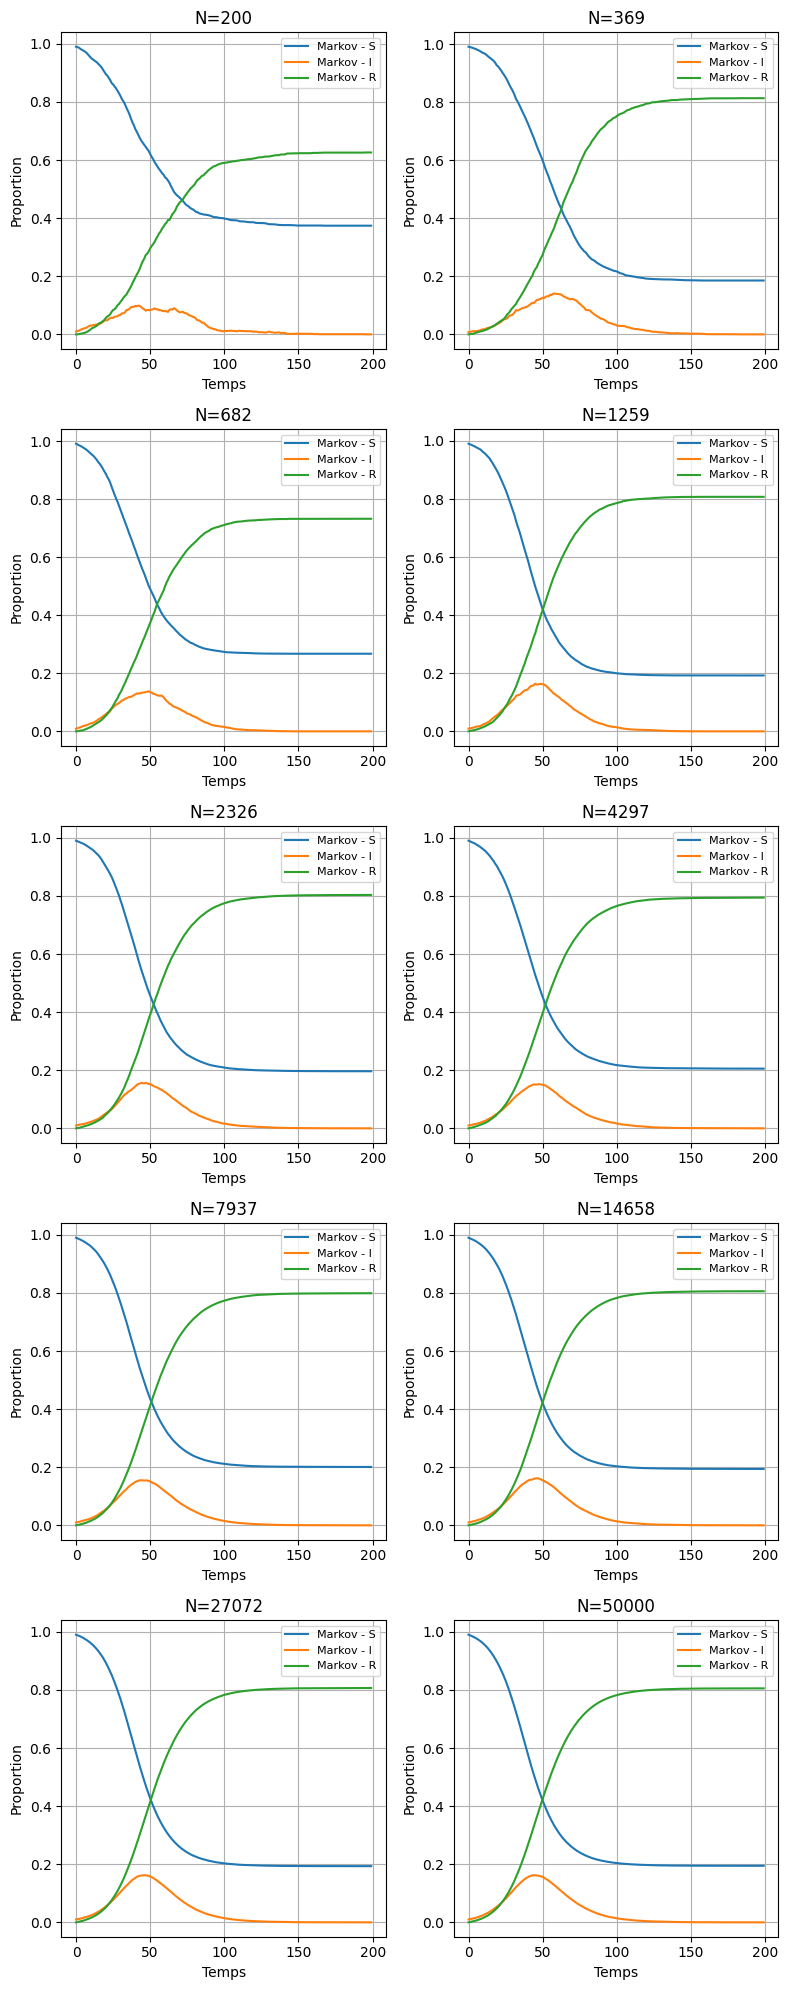

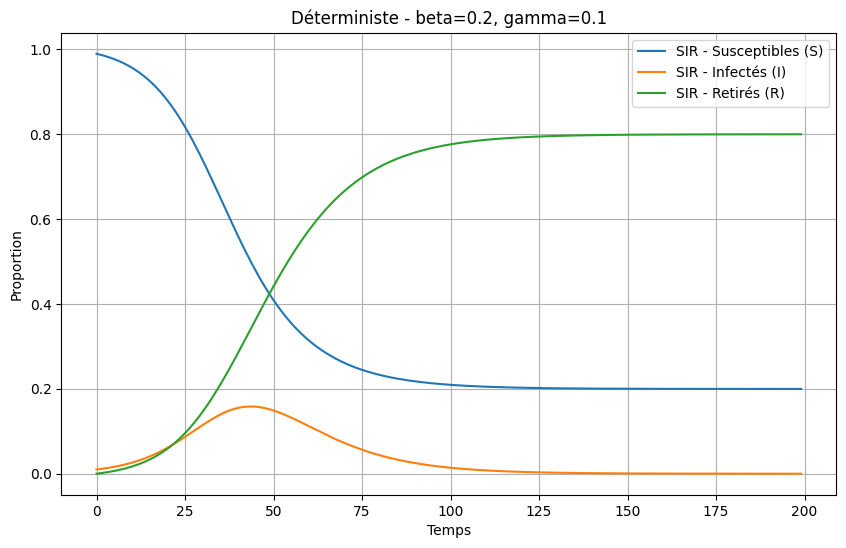

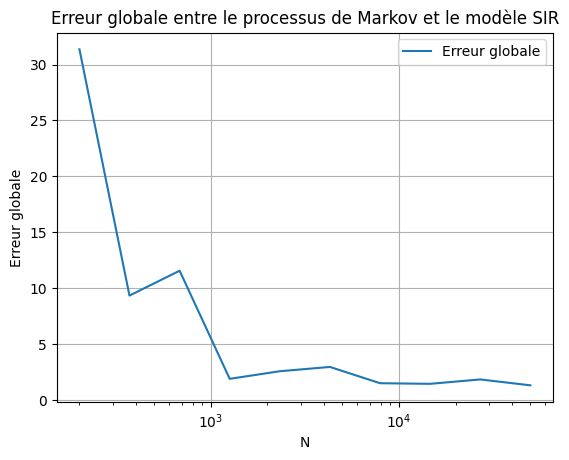

In [10]:
comparaison(0.2, 0.1, np.geomspace(200,50000,num=10,dtype=int), temps_max=200)

**Observations :** On observe bien la convergence du processus de Markov vers celui déterministe grace :
* les graphes qui sont de plus en plus similaire (on voit la bosse des infectés se recentrer et devenir plus lisse au fur et à mesure que $N$ augmente)
* par le calcul de l'erreur global qui décroit lorsque N augmente.

---

## 6. Question Ouverte - Comment extraire β et γ d’un vrai jeu de données ?

On effectue dans un premier temps un prétraitement de la donnée fournie. Pour cela on filtre sur le code départmental (`dep`), puis on trie les lignes par date (`jour`) et remet la colonne `jour` en index si besoin. Puis, on construis trois colonnes :  
- $I  = incid\_ hosp + incid\_ rea$ : hos + réa ≈ infectieux “visibles” du jour
- $R  = incid\_ dc + incid\_ rad$ : dc + rad ≈ retirés (morts + guéris)
- $S  = N\_ pop - I - R$ : reste de la population  

On néglige ici les infections non hospitalisées.  

In [11]:
import pandas as pd

data = pd.read_csv('donnees-covid.csv', sep=';')

print(data.columns)
data.head(10)

Index(['dep', 'jour', 'incid_hosp', 'incid_rea', 'incid_dc', 'incid_rad'], dtype='object')


,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
0,1,2020-03-19,1,0,0,0
1,1,2020-03-20,0,0,0,1
2,1,2020-03-21,3,0,0,0
3,1,2020-03-22,3,1,0,1
4,1,2020-03-23,14,1,0,5
5,1,2020-03-24,11,1,0,4
6,1,2020-03-25,13,2,0,5
7,1,2020-03-26,14,3,2,2
8,1,2020-03-27,14,2,0,0
9,1,2020-03-28,7,3,1,3


In [12]:
def preparer_donnees_dep(data, dep, population_dep):
    # Filtrer sur un département spécifique
    df_dep = data[data['dep'] == str(dep)].copy()
    df_dep = df_dep.sort_values(by='jour')
    
    # Calcul des colonnes utiles
    df_dep['I'] = df_dep['incid_hosp'] + df_dep['incid_rea'] # hospitalisations = infectés actifs approximés
    df_dep['R'] = df_dep['incid_dc'] + df_dep['incid_rad']  # retirés = décès + guéris
    df_dep['S'] = population_dep - df_dep['I'] - df_dep['R']  # susceptibles restants

    return df_dep

In [13]:
# Exemple pour Paris (75)
population_paris = 2161000  # Population estimée

df_paris = preparer_donnees_dep(data, 75, population_dep=population_paris)

df_paris.head(10)

,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad,I,R,S
19800,75,2020-03-19,167,41,11,31,208,42,2160750
19801,75,2020-03-20,120,21,5,28,141,33,2160826
19802,75,2020-03-21,138,34,7,35,172,42,2160786
19803,75,2020-03-22,147,31,4,33,178,37,2160785
19804,75,2020-03-23,189,31,18,33,220,51,2160729
19805,75,2020-03-24,209,70,21,35,279,56,2160665
19806,75,2020-03-25,316,66,32,62,382,94,2160524
19807,75,2020-03-26,276,66,28,65,342,93,2160565
19808,75,2020-03-27,270,76,42,82,346,124,2160530
19809,75,2020-03-28,346,76,31,66,422,97,2160481


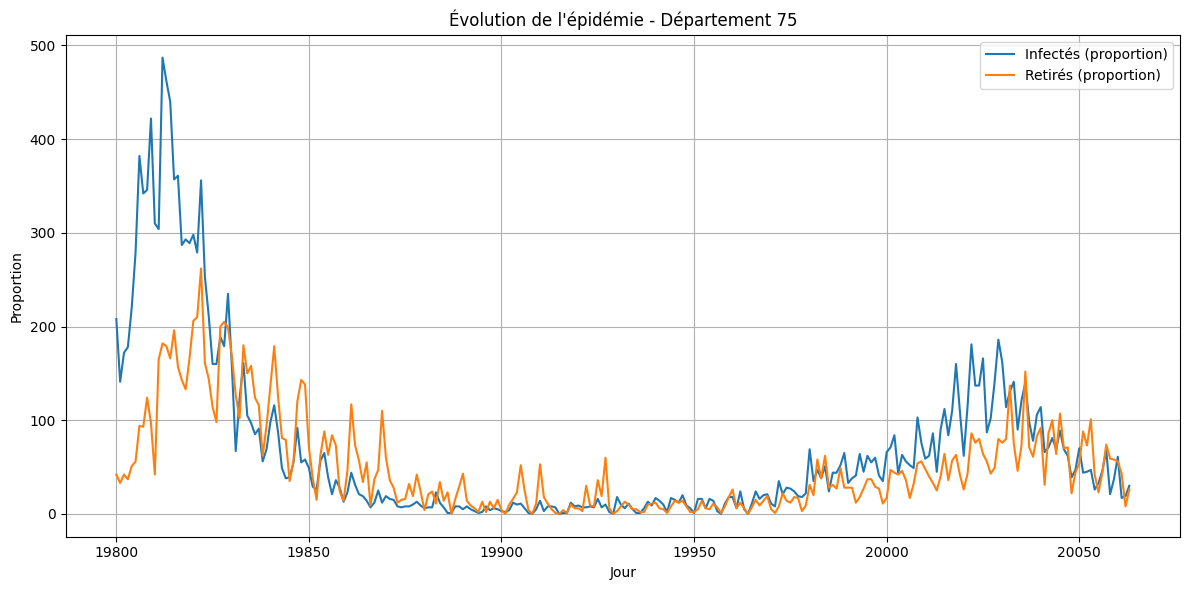

In [14]:
plt.figure(figsize=(12,6))
plt.plot( df_paris['I'], label='Infectés (proportion)')
plt.plot( df_paris['R'], label='Retirés (proportion)')
plt.xlabel('Jour')
plt.ylabel('Proportion')
plt.title('Évolution de l\'épidémie - Département 75')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Ce qu'on pourrait alors faire, c'est adapter le SIR continu  
$$
\dot R=\gamma I,\qquad\dot I=\beta S I-\gamma I.
$$

en remplaçant les dérivées par des différences discrètes :
$$
\hat\gamma(t)=\frac{R_{t+1}-R_t}{I_t},\qquad
\hat\beta(t)=\frac{I_{t+1}-I_t+\hat\gamma(t)\,I_t}{S_t\,I_t}.
$$

Il faudra alors jetter les jours où $I_t=0$ pour éviter des divisions par zéro. On pourra aussi tenter de réduire le bruit qui semble très présent sur la figure ci dessus, en lissant sur une semaine.

In [15]:
def estimer_beta_gamma(df, window=7, seuil_I=20):
    Sm = df['S'].rolling(window, center=True).mean()
    Im = df['I'].rolling(window, center=True).mean()
    Rm = df['R'].rolling(window, center=True).mean()
    
    # passage au discret
    dR = Rm.diff()
    dI = Im.diff()

    # estimateurs 
    gamma_hat = dR / Im
    beta_hat  = (dI + gamma_hat*Im) / (Sm*Im)

    beta_mean  = beta_hat.mean()
    gamma_mean = gamma_hat.mean()

    return beta_mean, gamma_mean, beta_hat, gamma_hat

In [16]:
beta,gamma,_,_ = estimer_beta_gamma(df_paris)

print(f"Beta = {-beta:.3e}")
print(f"Gamma = {-gamma:.3e}")
print(f"R0 = {beta/gamma:.10f}")

Beta = 1.842e-08
Gamma = 2.900e-02
R0 = 0.0000006352


On observe que le $R_0$ trouvé est très très proche de 0 ... ce qui semble incohérent car cela signifierait que l'epidémie n'a quasiment pas eu lieu.

Peut etre que notre approche n'est pas la meilleure et qu'il faudrait en utiliser une autre.